In [60]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [50]:
# --- Répertoires de résultats ---
os.makedirs("results/training", exist_ok=True)

In [51]:
# --- Hyperparamètres ---
EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
patience = 5  # Early stopping
IMG_SIZE = 224

In [52]:
num_classes = len(class_names)
print("Nombre de classes :", num_classes)

Nombre de classes : 4


In [53]:
# --- Charger ConvNeXt Tiny pré-entraîné ---
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

In [ ]:
# --- Adapter classifier avec Flatten, Dropout et 4 classes ---
model.classifier = nn.Sequential(
    nn.Flatten(),  
    nn.LayerNorm(768, eps=1e-06, elementwise_affine=True),
    nn.Dropout(p=0.3),
    nn.Linear(768, num_classes)
)

model = model.to(device)


In [55]:
# --- Criterion et Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [56]:
# --- Variables pour Early Stopping et métriques ---
best_val_loss = float('inf')
counter = 0
train_losses, train_accs, val_losses, val_accs = [], [], [], []

In [57]:
# --- Boucle d'entraînement ---
for epoch in range(EPOCHS):
    # --- Entraînement ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
      # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
 # --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "results/training/best_convnext_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping à l'époque {epoch+1}")
            break

Epoch 1/50: 100%|██████████| 179/179 [26:13<00:00,  8.79s/it]


Epoch 1/50 | Train Loss: 0.7893 | Train Acc: 0.6667 | Val Loss: 0.5647 | Val Acc: 0.7864


Epoch 2/50: 100%|██████████| 179/179 [23:44<00:00,  7.96s/it]


Epoch 2/50 | Train Loss: 0.3190 | Train Acc: 0.8860 | Val Loss: 0.3229 | Val Acc: 0.8734


Epoch 3/50: 100%|██████████| 179/179 [23:47<00:00,  7.98s/it]


Epoch 3/50 | Train Loss: 0.2080 | Train Acc: 0.9259 | Val Loss: 0.1586 | Val Acc: 0.9466


Epoch 4/50: 100%|██████████| 179/179 [22:36<00:00,  7.58s/it]


Epoch 4/50 | Train Loss: 0.1734 | Train Acc: 0.9396 | Val Loss: 0.0984 | Val Acc: 0.9664


Epoch 5/50: 100%|██████████| 179/179 [21:17<00:00,  7.13s/it]


Epoch 5/50 | Train Loss: 0.1457 | Train Acc: 0.9531 | Val Loss: 0.1336 | Val Acc: 0.9558


Epoch 6/50: 100%|██████████| 179/179 [21:19<00:00,  7.15s/it]


Epoch 6/50 | Train Loss: 0.1308 | Train Acc: 0.9552 | Val Loss: 0.0610 | Val Acc: 0.9840


Epoch 7/50: 100%|██████████| 179/179 [21:15<00:00,  7.12s/it]


Epoch 7/50 | Train Loss: 0.0952 | Train Acc: 0.9659 | Val Loss: 0.0736 | Val Acc: 0.9741


Epoch 8/50: 100%|██████████| 179/179 [21:15<00:00,  7.13s/it]


Epoch 8/50 | Train Loss: 0.0769 | Train Acc: 0.9758 | Val Loss: 0.0625 | Val Acc: 0.9817


Epoch 9/50: 100%|██████████| 179/179 [21:17<00:00,  7.14s/it]


Epoch 9/50 | Train Loss: 0.1095 | Train Acc: 0.9653 | Val Loss: 0.2060 | Val Acc: 0.9268


Epoch 10/50: 100%|██████████| 179/179 [21:45<00:00,  7.29s/it]


Epoch 10/50 | Train Loss: 0.0914 | Train Acc: 0.9692 | Val Loss: 0.0714 | Val Acc: 0.9779


Epoch 11/50: 100%|██████████| 179/179 [24:27<00:00,  8.20s/it]


Epoch 11/50 | Train Loss: 0.0682 | Train Acc: 0.9783 | Val Loss: 0.0333 | Val Acc: 0.9908


Epoch 12/50: 100%|██████████| 179/179 [26:13<00:00,  8.79s/it]


Epoch 12/50 | Train Loss: 0.0763 | Train Acc: 0.9751 | Val Loss: 0.0495 | Val Acc: 0.9863


Epoch 13/50: 100%|██████████| 179/179 [26:30<00:00,  8.88s/it]


Epoch 13/50 | Train Loss: 0.0517 | Train Acc: 0.9825 | Val Loss: 0.0469 | Val Acc: 0.9886


Epoch 14/50: 100%|██████████| 179/179 [26:24<00:00,  8.85s/it]


Epoch 14/50 | Train Loss: 0.0548 | Train Acc: 0.9830 | Val Loss: 0.0895 | Val Acc: 0.9710


Epoch 15/50: 100%|██████████| 179/179 [26:20<00:00,  8.83s/it]


Epoch 15/50 | Train Loss: 0.0677 | Train Acc: 0.9765 | Val Loss: 0.1017 | Val Acc: 0.9664


Epoch 16/50: 100%|██████████| 179/179 [26:25<00:00,  8.86s/it]


Epoch 16/50 | Train Loss: 0.0674 | Train Acc: 0.9800 | Val Loss: 0.0696 | Val Acc: 0.9756
Early stopping à l'époque 16


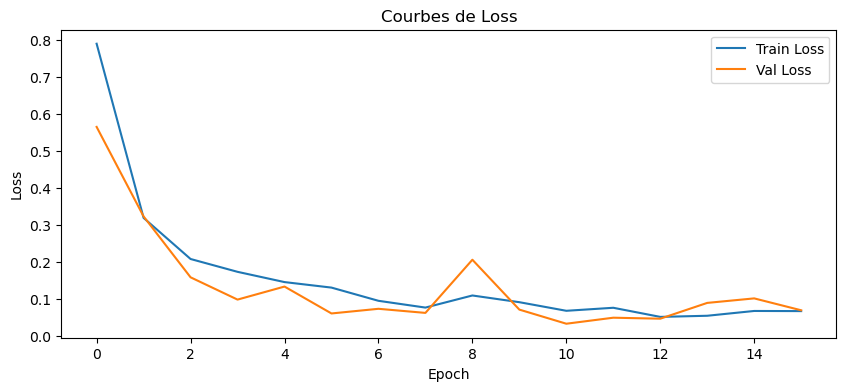

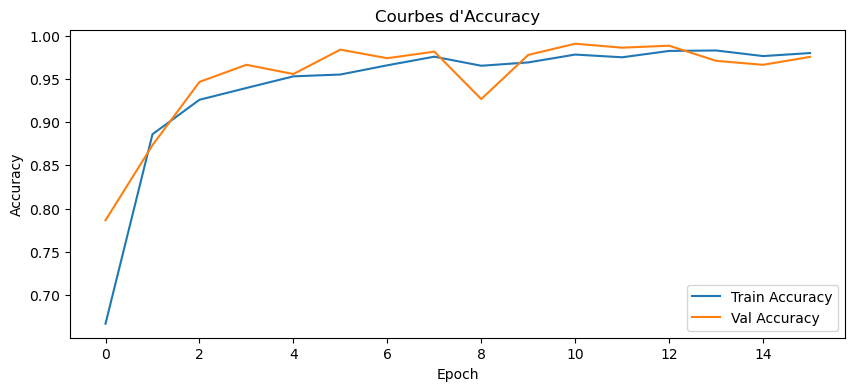

In [61]:
# --- Sauvegarder courbes Loss et Accuracy ---
plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Courbes de Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("results/training/loss_curve.png")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Courbes d'Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("results/training/accuracy_curve.png")
plt.show()

In [62]:
# --- Sauvegarder logs dans CSV ---
logs = pd.DataFrame({
    "Epoch": list(range(1, len(train_losses)+1)),
    "Train_Loss": train_losses,
    "Train_Acc": train_accs,
    "Val_Loss": val_losses,
    "Val_Acc": val_accs
})
logs.to_csv("results/training/training_logs.csv", index=False)
logs.head()

,Epoch,Train_Loss,Train_Acc,Val_Loss,Val_Acc
0,1,0.789265,0.666667,0.564660,0.786423
1,2,0.319020,0.886029,0.322930,0.873379
2,3,0.208042,0.925945,0.158588,0.946606
3,4,0.173386,0.939601,0.098420,0.966438
4,5,0.145706,0.953081,0.133614,0.955759
